<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/py-ml-dl-tf/Keras/Keras_mnist_analysis_2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keras example: mnist analysis by simple NN

In [1]:
%%time
from keras.datasets import mnist
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

Using TensorFlow backend.


CPU times: user 1.24 s, sys: 186 ms, total: 1.43 s
Wall time: 1.44 s


In [2]:
print(X_train0.shape, X_train0.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test0.shape, y_test0.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

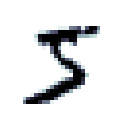

In [4]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train0[0], cmap=mpl.cm.bone_r)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

### Show images of numbers

In [0]:
# 추가 사항
import numpy as np
# import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

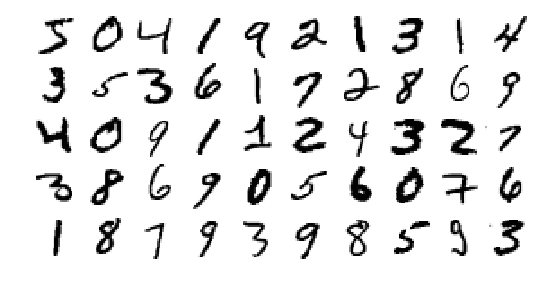

In [6]:
plt.figure(figsize=(9,9))
example_images = np.r_[X_train0[:50]]
plot_digits(example_images, images_per_row=10)

plt.show()

### 데이터를 float 타입으로 바꾸고 스케일링한다.

In [7]:
X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
print(X_train.shape, X_train.dtype)

(60000, 784) float32


### y 데이터는 One-Hot-Encoding 을 한다.

In [8]:
y_train0[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [10]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train0, 10)
y_test = np_utils.to_categorical(y_test0, 10)
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

***

## 신경망 구현 순서

### Keras 를 사용하면 다음과 같은 순서로 신경망을 구성할 수 있다.

1. Sequential 모형 클래스 객체 생성
2. add 메서드로 layer 추가.
    - Dense layer 가 가장 일반적인 신경망
    - 입력단부터 순차적으로 추가한다.
    - 레이어는 출력 뉴런 갯수를 첫번째 인수로 받는다.
    - 최초의 레이어는 input_dim 인수로 입력 크기를 설정해야 한다.
    - activation 인수로 activation 함수 설정
3. compile 메서드로 모형 완성.
    - loss인수로 Loss 함수 설정
    - optimizer 인수로 최적화 알고리즘 설정
    - metrics 인수로 트레이닝 단계에서 기록할 성능 기준 설정
4. fit 메서드로 트레이닝
    - nb_epoch 로 epoch 횟수 설정
    - batch_size 로 mini batch size 설정
    - metrics 인수로 설정한 성능 기준 기록을 출력으로 반환
    - Jupyter Notebook을 사용할 때는 verbose=2로 설정하여 progress bar 가 나오지 않도록 설정한다.

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
import numpy as np

In [0]:
# Learning model
np.random.seed(0)

model = Sequential()
model.add(Dense(15, input_dim=784, activation="sigmoid"))  # firsr layer
model.add(Dense(10, activation="sigmoid")) # output layer

> 만들어진 모형은 model_to_dot 명령이나 summary 명령으로 모델 내부의 layers 리스트를 살펴봄으로써 내부 구조를 확인할 수 있다.

In [38]:
# https://laujohn.com/2018/09/24/Plot-Keras-Model-in-Colaboratory/
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Double check with Python 3


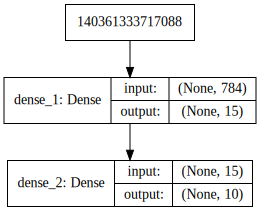

In [39]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


In [0]:
l1 = model.layers[0]
l2 = model.layers[1]

In [43]:
l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params()

('dense_1', keras.layers.core.Dense, (None, 15), 'sigmoid', 11775)

In [44]:
l2.name, type(l1), l2.output_shape, l2.activation.__name__, l2.count_params()

('dense_2', keras.layers.core.Dense, (None, 10), 'sigmoid', 160)

## fit 메서드로 트레이닝

In [0]:
model.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [46]:
%%time
hist = model.fit(X_train, Y_train, 
                 epochs=30, batch_size=100, 
                 validation_data=(X_test, Y_test), 
                 verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 1s 21us/step - loss: 0.0251 - acc: 0.8859 - val_loss: 0.0241 - val_acc: 0.8911
Epoch 2/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0246 - acc: 0.8871 - val_loss: 0.0236 - val_acc: 0.8928
Epoch 3/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0242 - acc: 0.8884 - val_loss: 0.0232 - val_acc: 0.8946
Epoch 4/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0238 - acc: 0.8898 - val_loss: 0.0229 - val_acc: 0.8956
Epoch 5/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0234 - acc: 0.8912 - val_loss: 0.0225 - val_acc: 0.8961
Epoch 6/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0231 - acc: 0.8917 - val_loss: 0.0222 - val_acc: 0.8972
Epoch 7/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.0228 - acc: 0.8928 - val_loss: 0.0219 - val_acc

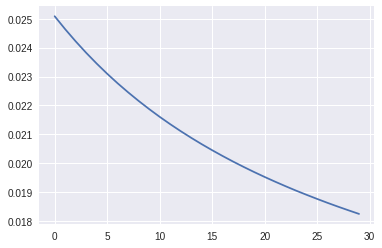

In [47]:
# Plot performance
plt.plot(hist.history['loss'])
plt.show()

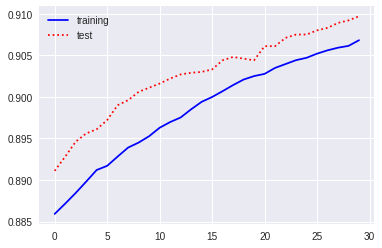

In [48]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

## 가중치 정보

> 트레이닝이 끝난 모형의 가중치 정보는 get_weights 메서드로 구할 수 있다. 이 메서드는 w 값과 b 값을 출력한다.

In [21]:
w1 = l1.get_weights()  # 784*15 + 15 = 11775
w1[0].shape, w1[1].shape

((784, 15), (15,))

In [22]:
w2 = l2.get_weights()  # 15*10 + 10 = 160
w2[0].shape, w2[1].shape

((15, 10), (10,))

## 모형의 사용

> 트레이닝이 끝난 모형은 predict 메서드로 y 값을 출력하거나 출력된 y값을 각 클래스에 대한 판별함수로 가정하고 predict_classes 메서드로 classification을 할 수 있다.

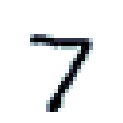

In [23]:
plt.figure(figsize=(2, 2))
plt.imshow(X_test0[0], cmap=mpl.cm.bone_r)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
model.predict(X_test[:1, :])  # Probabilitic prediction viq one-hot encoding of labels

array([[0.01766422, 0.01915493, 0.0131979 , 0.028706  , 0.01252179,
        0.0572116 , 0.01232646, 0.94186133, 0.00762723, 0.05534772]],
      dtype=float32)

In [27]:
model.predict_classes(X_test[:1, :], verbose=0)

array([7])

## 모형의 저장

>  트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장하였다가 나중에 load 명령으로 불러 사용할 수 있다.

In [0]:
model.save('my_model.hdf5')
# del model

In [29]:
from keras.models import load_model

model2 = load_model('my_model.hdf5')
model2.predict_classes(X_test[:1, :], verbose=0)

array([7])

In [30]:
model2.predict_classes(X_test[:10, :], verbose=0)

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [31]:
y_test0[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

### 테스트 데이터에 대한 예측 정확도 계산 

In [32]:
# Wrong prediction
model2.predict_classes(X_test[8:9, :], verbose=1)

1/1 [==============================] - 0s 919us/step


array([6])

In [33]:
y_test0[8]

5

In [34]:
# 전체 테스트 데이터에 대한 예측
x_pred = model2.predict_classes(X_test, verbose=1)

10000/10000 [==============================] - 0s 15us/step


In [35]:
t_count = np.sum(x_pred==y_test0) # True positive
f_count = np.sum(x_pred!=y_test0) # False positive
f_count==10000-t_count

True

In [36]:
t_count,f_count

(8904, 1096)

In [37]:
accuracy = t_count/10000*100
accuracy

89.03999999999999

### Accuracy of predicting test numbers is around 89% in simple neural network model.